### Import data

In [ ]:
import CSV
using LeastSquaresOptim, DifferentialEquations, DelayDiffEq, DiffEqBase, Optim, Plots, Statistics, DataFrames

# Import data
data = CSV.read("..//data//gem.csv")
total = CSV.read("..//data//gem_pop.csv")

# delete the extra index column which strats at 0 
deletecols!(data, :Column1)
deletecols!(total, :Column1)

# get the number of data points
len = length(data[:,1])
time = data[:,1]

# just to make sure all have the same size
total_old = total[1:192,2];
G2_old = data[1:192,2];

# rescaling the experimental data assuming we have 20 initial cells for each trial
init_cells = 20.0
total_new = init_cells * total_old
G2_new = 0.01*total_new.*G2_old;
G1_new = total_new .- G2_new;
g2_0 = init_cells*(G2_old[1]/100.0)
g1_0 = init_cells*(1- (G2_old[1]/100.0))

plot(G1_new, label = "G1")
plot!(G2_new, label = "G2")
plot!(total_new, label = "total")
print(g1_0, "\n", g2_0)

# defining csv to hold parameters
# param_holder_tax2_dde = zeros(8,9);
# param_holder_lap_ode = zeros(5,9);

### ODE solve

In [ ]:
function ODEmodel(du, u, p, t)

    du[1] = -p[1]*u[1] + 2*p[2]*u[2] - p[3]*u[1]
    du[2] = p[1]*u[1] - p[2]*u[2] - p[4]*u[2]
end

function ODEsolve(par)
    t = LinRange(0.0, 95.5, 192)
    tspan = (0.0, 95.5)
    u0 = [g1_0, g2_0]
    prob = ODEProblem(ODEmodel, u0, tspan, par)
    solve(prob, Tsit5())
end

function residuals(par)
    t = LinRange(0.0, 95.5, 192)
    res = zeros(2, 192)
    sol = ODEsolve(par)
    res[2, :] = sol(t, idxs = 1).u - G1_new
    res[1, :] = sol(t, idxs = 2).u - G2_new
    return res
end

p = [8.870525323648254,8.492087168644503,0.4344732303091874,7.678477905020965]
t = LinRange(0.0, 95.5, 192)
low = [0.0, 0.0, 0.0, 0.01]

# result_ode = optimize(residuals, p, Dogleg(), lower = low)
result_ode = optimize(residuals, p, LevenbergMarquardt(), lower = low)

In [ ]:
t = LinRange(0.0, 95.5, 192)
params = result_ode.minimizer
# params =  [0.129992538367695,0.04567232337751,0.017989068250636, 0.0601300854109052327189]
# param_holder_lap_ode = CSV.read("params_lap_ODE.csv")
# param_holder_lap_ode[:, 7] = params
# CSV.write("params_lap_ODE.csv", DataFrame(param_holder_lap_ode))


# sol = DDEsolve(params)

# plot(t, sol(t, idxs=2).u, label = "G1 est", legend =:topleft)
# plot!(t, G1_new, label = "G1")
# plot!(t, sol(t, idxs=1).u, title = "DOX Trial 2 DDE", label = "G2 est")
# plot!(t, G2_new, label = "G2")
# plot!(t, (sol(t, idxs=2).u + sol(t, idxs=1).u), label = "total est")
# plot!(t, total_new, label = "total")
# savefig("DOX_2_DDE.png")


t_new = LinRange(0.0, 195.5, 292)
tspan_new = (0.0, 195.5)
u0_new = [g1_0, g2_0]
prob_new = ODEProblem(ODEmodel, u0_new, tspan_new, params)
solution = solve(prob_new, Tsit5())

plot(t_new, solution(t_new, idxs=1).u, label = "G1 est", dpi = 150, xlabel = "time [hours]", ylabel = "# of cells")
plot!(t, G1_new, label = "G1", dpi = 150)
plot!(t_new, solution(t_new, idxs=2).u, label = "G2 est", title = "Lap. Trial 7 ODE", legend=:topleft, dpi = 150)
plot!(t, G2_new, label = "G2", dpi = 150)
plot!(t_new, (solution(t_new, idxs=2).u + solution(t_new, idxs=1).u), label = "total est", dpi = 150)
plot!(t, total_new, label = "total", dpi = 150)
savefig("lap_7_ode_long.png")

In [ ]:
# param_holder_lap_ode[:, 1] = ["alpha", "beta", "gamma1", "gamma2"]
# CSV.write("params_lap_ODE.csv", DataFrame(param_holder_lap_ode))

### Using Dogleg()/ LevenbergMarquardt() for optimization DDE

In [110]:
# This model doesn't assume delay for dying
function DDEmodel(du, u, h, p, t)
    du[1] = -p[1]*(h(p, t-p[3])[1]) + 2*p[2]*(h(p, t-p[4])[2]) - p[6]*u[1]
    du[2] = p[1]*(h(p, t-p[3])[1]) - p[2]*(h(p, t-p[4])[2]) - p[7]*u[2]
end

function DDEsolve(pp)
    lags = [pp[3], pp[4]]
    h(p, t) = pp[5]*ones(2)
    t = LinRange(0.0, 95.5, 192)

    tspan = (0.0, 95.5)
    u0 = [g1_0, g2_0]
    prob = DDEProblem(DDEmodel, u0, h, tspan, pp; constant_lags = lags)
    solve(prob)
end

function resid(pp)
    t = LinRange(0.0, 95.5, 192)
    res = zeros(2, 192)
    sol = DDEsolve(pp)
    res[1, :] = sol(t, idxs=1).u - G1_new
    res[2, :] = sol(t, idxs=2).u - G2_new
    return res
end

# We could just find the best guess for the first trial and then just substitude the previous estimated parameter 
# to find the next trial as our initial guess (mostl of the time works well!)
p  = [0.009264, 0.0024789, 8.510857, 20.9084, 30.1584, 0.0099793, 0.01888814]

# setting lowest delay for tau1 to be half an hour and for tau2 to be 3 hours.
low = [0.0001, 0.0001, 0.5, 2.0, 1.0, 0.0001, 0.0001]
upp = [0.5, 0.5, 50.0, 50.0, 400.0, 0.5, 0.5]
# results_dde = optimize(resid, p, Dogleg(), lower = low)
results_dde = optimize(resid, p, LevenbergMarquardt(), lower = low, upper = upp)

Results of Optimization Algorithm
 * Algorithm: LevenbergMarquardt
 * Minimizer: [0.24048794525879783,0.14730808168056464,0.5086744063044734,5.2887268732667385,12.062168451099687,0.00010000040991119677,0.19898030978735812]
 * Sum of squares at Minimum: 611.802692
 * Iterations: 298
 * Convergence: true
 * |x - x'| < 1.0e-08: true
 * |f(x) - f(x')| / |f(x)| < 1.0e-08: false
 * |g(x)| < 1.0e-08: false
 * Function Calls: 299
 * Gradient Calls: 199
 * Multiplication Calls: 894


### Solve and Plot for Dogleg() optimization

In [112]:
t = LinRange(0.0, 95.5, 192)
params = results_dde.minimizer
# params = [0.009264, 0.0024789, 8.510857, 20.9084, 30.1584, 0.0099793, 0.01888814]
print(params)
# param_holder_tax2_dde = CSV.read("params_tax2_DDE.csv")

param_holder_tax2_dde[1:7, 9] = params 
CSV.write("params_tax2_DDE.csv",  DataFrame(param_holder_tax2_dde))



# sol = DDEsolve(params)

# plot(t, sol(t, idxs=2).u, label = "G1 est", legend =:topleft)
# plot!(t, G1_new, label = "G1")
# plot!(t, sol(t, idxs=1).u, title = "DOX Trial 2 DDE", label = "G2 est")
# plot!(t, G2_new, label = "G2")
# plot!(t, (sol(t, idxs=2).u + sol(t, idxs=1).u), label = "total est")
# plot!(t, total_new, label = "total")
# savefig("DOX_2_DDE.png")

lags = [params[3], params[4]]
t_new = LinRange(0.0, 195.5, 292)
h(p, t_new) = params[5]*ones(2)
tspan_new = (0.0, 195.5)
u0_new = [g1_0, g2_0]
prob_new = DDEProblem(DDEmodel, u0_new, h, tspan_new, params; constant_lags = lags)
solution = solve(prob_new, MethodOfSteps(Tsit5()))

plot(t_new, solution(t_new, idxs=1).u, label = "G1 est", dpi = 150, xlabel = "time [hours]", ylabel = "# of cells")
plot!(t, G1_new, label = "G1", dpi = 150)
plot!(t_new, solution(t_new, idxs=2).u, label = "G2 est", title = "Taxol2. Trial 9 DDE", legend=:topright, dpi = 150)
plot!(t, G2_new, label = "G2", dpi = 150)
plot!(t_new, (solution(t_new, idxs=2).u + solution(t_new, idxs=1).u), label = "total est", dpi = 150)
plot!(t, total_new, label = "total", dpi = 150)
savefig("tax2_9_dde_long.png")

[0.240488, 0.147308, 0.508674, 5.28873, 12.0622, 0.0001, 0.19898]

In [124]:
# param_holder_tax2_dde = CSV.read("params_tax2_DDE.csv")
# param_holder_tax2_dde[:, 1] = ["alpha", "beta", "tau1", "tau2", "history", "gamma1", "gamma2", "drug conc."]
# CSV.write("params_tax2_DDE.csv",  DataFrame(param_holder_tax2_dde))
# param_holder_tax2_dde[8, 2:end] = [0.0, 0.1, 1.0, 2.0, 3.0, 5.0, 7.5, 15.0] 

### To plot parameters against drug concentrations

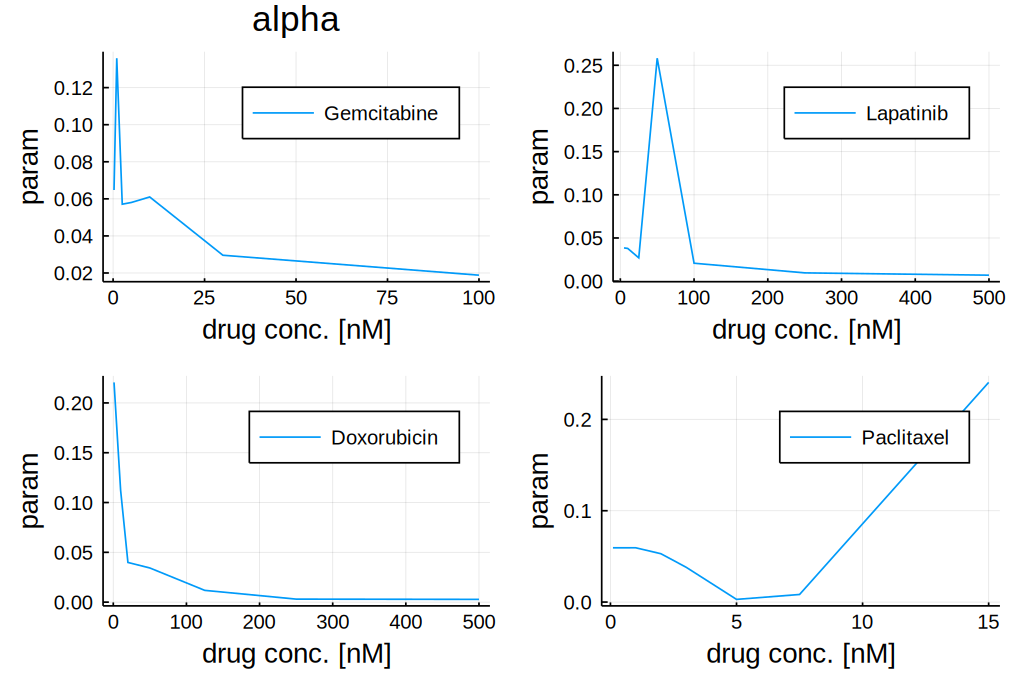

In [130]:
using Plots, CSV;

# Reading the file containing params
param_lap_dde = CSV.read(".//figures//Lapatinib//dde//params_lap_DDE.csv")
param_gem_dde = CSV.read(".//figures//Gem//dde//params_gem_DDE.csv")
param_dox_dde = CSV.read(".//figures//Dox//dde//params_dox_DDE.csv")
param_taxol1_dde = CSV.read(".//figures//taxol//dde//params_taxol1_DDE.csv")
param_tax2_dde = CSV.read(".//figures//taxol2//dde//params_tax2_DDE.csv")

# Convert the DataFrame to Matrix for plotting
lap = convert(Matrix, param_lap_dde[:,3:end])
gem = convert(Matrix, param_gem_dde[:,3:end])
dox = convert(Matrix, param_dox_dde[:,3:end])
tax = convert(Matrix, param_taxol1_dde[:,3:end])
tax2 = convert(Matrix, param_tax2_dde[:, 3:end])

function plot_param_conc(lap, gem, dox, tax, i, param)
    """ This function to plot parameter vs. concentraition.
    Arguments:
    ----------
    lap, gem, dox, tax: DataFrame containing parameters of treating AU565 human breast cancer cells with Lapatinib, Gemcitabine, Doxorubicin, and   Paclitaxel1, respectively.
    i {int.}: If it is for DDE: A number between 1 and 7, which points to the parameters: [alpha, beta, tau1, tau2, history, gamma1, gamma2]
              If it is for ODE: A number between 1 and 4, which points to the parameters: [alpha, beta, gamma1, gamma2]
    param {str.}: a string used for the title of plots, to show which parameter we are plotting.
    Returns:
    --------
    Returns a 2x2 plot for four drugs. 
    
    """
    p1 = plot(gem[8, :], gem[i, :], label = "Gemcitabine", title = param, xlabel = "drug conc. [nM]", ylabel = "param", yticks = 0.0:0.02:0.5)
    p2 = plot(lap[8, :], lap[i, :], label = "Lapatinib", xlabel = "drug conc. [nM]", ylabel = "param", yticks = 0.0:0.05:0.5)
    p3 = plot(dox[8, :], dox[i, :], label = "Doxorubicin", xlabel = "drug conc. [nM]", ylabel = "param", yticks = 0.0:0.05:0.5)
    p4 = plot(tax[8, :], tax[i, :], label = "Paclitaxel", xlabel = "drug conc. [nM]", ylabel = "param", yticks = 0.0:0.1:1.0)
    plot(p1, p2, p3, p4, figsize = (18, 8), dpi = 170)
end

plot_param_conc(lap, gem, dox, tax2, 1 , "alpha")
# savefig()